In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

In [3]:
img = mpimg.imread('warped_example.jpg')
#normalize
img=img/255

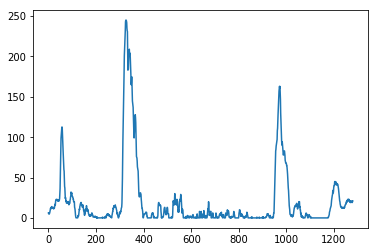

In [4]:
def draw_hist(img):
    height=img.shape[0]
    width=img.shape[1]
    bottom_half = img[(height//2):,:]

    #axis=0 means vertically calculating sum of pixels and and its value represented as histogram
    hist = np.sum(bottom_half,axis=0)
    
    return hist


hist = draw_hist(img)
plt.plot(hist)

In [5]:
def find_peak(hist):
    mid_p=np.int(hist.shape[0]//2)
    left_lane=np.argmax(hist[:mid_p])
    right_lane=np.argmax(hist[mid_p:])+mid_p
    return left_lane,right_lane


In [6]:
def lane_fit(img):
    hist=draw_hist(img)
    left,right=find_peak(hist)
    
    #sliding window parameters
    window_no=10
    height=(img.shape[0]//window_no)
    width=200
    margin=100
    pix_req_torecenter=50 #no of pixels required to be present in sliding window in order to recenter it
    left_lane_start=left
    right_lane_start=right
    
    #find non zero pixel indexes 
    non_zero_index=img.nonzero()
    non_zero_y=np.array(non_zero_index[0])
    non_zero_x=np.array(non_zero_index[1])
    
    #indexes found by moving sliding window having non zero value
    left_lane=[]
    right_lane=[]
    
    #creating image to 3d 
    vis=np.dstack((img,img,img))
    
    #sliding window
    for w in range(window_no):
        #find window boundaries
        win_y_bottom=img.shape[0]-w*height
        win_y_top=img.shape[0]-(w+1)*height
        win_left_low_x=left_lane_start-margin
        win_left_high_x=left_lane_start+margin
        win_right_low_x=right_lane_start-margin
        win_right_high_x=right_lane_start+margin
        
        #plt.imshow(vis)
        #plt.plot(win_left_low_x,win_y_top,'.')
        #draw boxes
        cv2.rectangle(vis,(win_left_low_x,win_y_bottom),( win_left_high_x,win_y_top),(0,255,0),3)
        cv2.rectangle(vis,(win_right_low_x,win_y_bottom),( win_right_high_x,win_y_top),(255,0,0),3)
        
        
        #find index i present in window so that nonzerox[i],nonzeroy[i] is the coordinates that is not zero and present in sliding window
        good_left_index = ((non_zero_y >= win_y_top) & (non_zero_y <win_y_bottom ) & 
        (non_zero_x >= win_left_low_x) &  (non_zero_x <win_left_high_x)).nonzero()[0] #getting indexes where a non zero value is there and getting its pixel value
        good_right_index = ((non_zero_y >=  win_y_top) & (non_zero_y <win_y_bottom) & 
        (non_zero_x >= win_right_low_x) &  (non_zero_x < win_right_high_x)).nonzero()[0]
        
        #append pixel to list
        left_lane.append(good_left_index)
        right_lane.append(good_right_index)
        
        if(len(good_left_index)>pix_req_torecenter):
            left_lane_start=np.int(np.mean(non_zero_x[good_left_index]))
        if(len(good_right_index)>pix_req_torecenter):
            right_lane_start=np.int(np.mean(non_zero_x[good_right_index]))
        
    left_lane=np.concatenate(left_lane)
    right_lane=np.concatenate(right_lane)
    
    leftx = non_zero_x[left_lane]
    lefty = non_zero_y[left_lane] 
    rightx = non_zero_x[right_lane] 
    righty = non_zero_y[right_lane] 
    
    return leftx,lefty,rightx,righty,vis
    
        

    
    
        
        
        

In [13]:
def polynomial_regression(img):
    x_left,y_left,x_right,y_right,vis=lane_fit(img)
    left_polyfit=np.polyfit(y_left,x_left,2)
    right_polyfit=np.polyfit(y_right,x_right,2)
    print(left_polyfit)
    print(right_polyfit)
    ycoords=np.linspace(0,(img.shape[0]-1),img.shape[0])
    
    try:
        left_fitx = left_polyfit[0] * ycoords**2 + left_polyfit[1] * ycoords + left_polyfit[2]
        right_fitx = right_polyfit[0] * ycoords**2 + right_polyfit[1] * ycoords + right_polyfit[2]
    except TypeError:
        print('Fitting to points failed')
        left_fitx = 1*ycoords**2 + 1*ycoords
        right_fitx = 1*ycoords**2 + 1*ycoords
    
    ## Visualization ##
    # Colors in the left and right lane regions
    vis[y_left, x_left] = [255, 0, 0]
    vis[y_right, x_right] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ycoords, color='yellow')
    plt.plot(right_fitx, ycoords, color='yellow')

    return left_fitx,right_fitx,ycoords,vis
    



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.18257793e-04 -3.88029241e-01  4.78175694e+02]
[ 4.19669853e-04 -4.79994684e-01  1.11527328e+03]


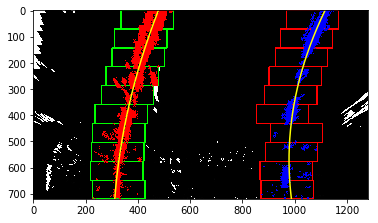

In [14]:
left,right,y,vis=polynomial_regression(img)
plt.imshow(vis)